In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
from IPython.display import display, HTML

from common import h5dataset, model_dnn, onnxexporter, trainer_gan

class Discriminator(model_dnn.ModelDNN):
    def __init__(self, name, input_size, embedding_size, hidden_size, output_size):
        super().__init__(name, input_size, embedding_size, hidden_size, output_size)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return super().forward(x)
    
    

    

In [2]:
# Plot model graph
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)

discriminator = Discriminator(
    name="JassGanDisc",
    input_size=73,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=1,
)

discriminator_graph = draw_graph(discriminator, (torch.zeros(1, 72).long(), torch.zeros(1, 1).long()), show_shapes=True)

model_svg = model_graph.visual_graph.pipe(format="svg").decode("utf-8")
discriminator_svg = discriminator_graph.visual_graph.pipe(format="svg").decode("utf-8")

display(HTML(
    f"""
    <div style="display: flex; flex-direction: row; gap: 40px;">
        <div>{model_svg}</div>
        <div>{discriminator_svg}</div>
    </div>
    """
))


(process:8272): Pango-WARNING **: 13:38:31.053: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:3060): Pango-WARNING **: 13:38:31.333: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


In [3]:

DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
MODLE_PATH = './models'
BATCH_SIZE = 256
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


#model.load_state_dict(torch.load(f"{MODLE_PATH}/JassPlayDNN_512_256_128.pth"))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
discriminator = discriminator.to(device)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
trainer = trainer_gan.TrainerGan(
    train_loader=train_loader,
    val_loader=val_loader,
    n_critic=1,
    n_gen=4,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [4]:
# train the model
trainer.train(NUM_EPOCHS, model, discriminator, optimizer, disc_optimizer)

Validation Epoch 1: 100%|██████████| 17333/17333 [01:11<00:00, 243.46it/s]


Epoch 1/2 - Generator Train Loss: -0.0750, Discriminator Train Loss: 0.1687, Generator Val Loss: 0.2587, Discriminator Val Loss: -0.4842


Validation Epoch 2: 100%|██████████| 17333/17333 [01:04<00:00, 269.23it/s]

Epoch 2/2 - Generator Train Loss: -0.0772, Discriminator Train Loss: 0.1607, Generator Val Loss: 0.2587, Discriminator Val Loss: -0.4842


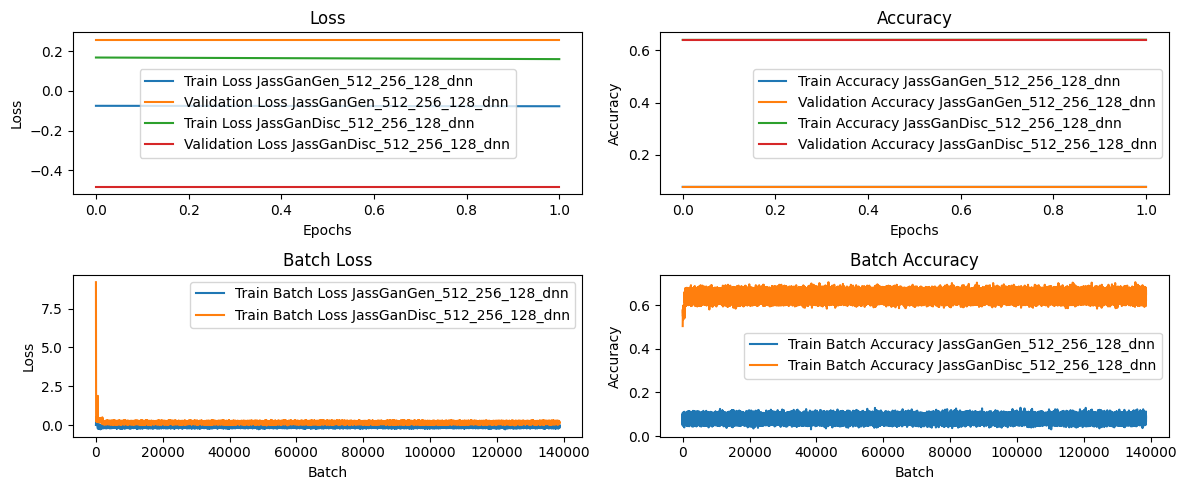

In [5]:
# create graphs
trainer.monitor.plot()

In [7]:
trainer.monitor.dump(MODLE_PATH + '/logs')

In [6]:
# export the model to ONNX
ONNX_PATH = './onnx/jass_gan_dnn.onnx'
model = model.to("cpu")
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    model_path=MODLE_PATH,
    output_path=ONNX_PATH
)

TypeError: onnx_exporter() got an unexpected keyword argument 'model_path'